### IGCI inspired notion of independence of mechanisms

The following notebook implements a measure of independence of mechanisms inspired by Information Geometric Causal Inference.

In [1]:
import jax.numpy as np   

from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
rng = random.PRNGKey(0)

### 1. Define a mixing function

In [2]:
from numpy import random as numpy_random

We introduce a moderately nonlinear mixing function in the form of a post-nonlinear model, where the linear mixing is given by an orthogonal matrix.

In [3]:
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=2)
A_inv = np.linalg.inv(A) 


def f_1(x):
    y = A @ x
    y = y**3
    return y

The inverse mixing is also easy to compute.

In [4]:
def f_1_inv(x):
    x = np.cbrt(x)
    y = A_inv @ x
    return y

In [5]:
# N:=Number of samples
N = 1000
S = numpy_random.uniform(low=-1.0, high=1.0, size=(2, N))

In [6]:
S.shape

(2, 1000)

In [7]:
import matplotlib.pyplot as plt

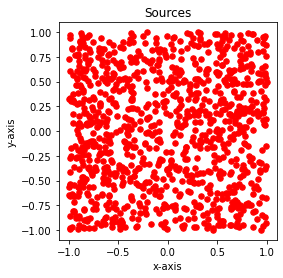

In [8]:
plt.scatter(S[0], S[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [9]:
X = f_1(S)
import matplotlib.pyplot as plt

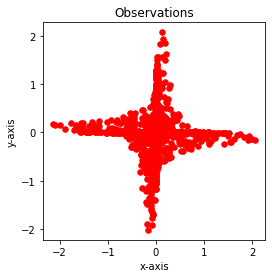

In [10]:
plt.scatter(X[0], X[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [11]:
S_ = f_1_inv(f_1(S))

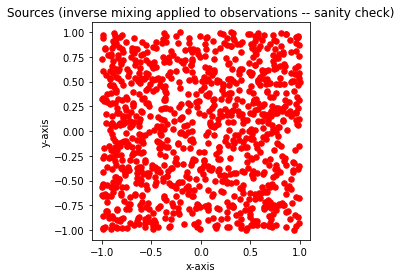

In [12]:
plt.scatter(S_[0], S_[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources (inverse mixing applied to observations -- sanity check)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2. Jacobian computation

For the Jacobian computation, we use the forward mode AD of Jax.

In [13]:
Jf_1 = jacfwd(f_1)

In [14]:
S_mock = np.array([1., 2.])

In [15]:
JX = Jf_1(S_mock)

In [16]:
JX.shape

(2, 2)

In [17]:
JX

DeviceArray([[ 7.791025 ,  3.1257255],
             [ 2.4594803, -6.1303763]], dtype=float32)

### 3. IGCI IM computation (Jacobian computed with Jax)

We implement a function computing the following quantity:

$$
\text{igci_im}(\mathbf{f}, \mathbf{s}) = \int \nabla f_1(\mathbf{s})^T \nabla f_2(\mathbf{s})p(\mathbf{s}) d\mathbf{s} - \int \nabla f_1(\mathbf{s})^T p(\mathbf{s}) d\mathbf{s} \int \nabla f_2(\mathbf{s})p(\mathbf{s}) d\mathbf{s}\,,
$$

where the integral over the density must be substituted with empirical estimates based on the available samples.

In [18]:
def igci_im(f, s):
    '''
    Computes a score based on the fine tuning between (...)
    
    Input:
    s: D x N dimensional array, D:= # of dimensions, , N:= # of samples
    f: invertible function f: R^D -> R^D
    
    Output:
    The difference between the (empirical estimate over the samples s of the) expected value of the scalar product of the 
    rows(columns) of the Jacobian and the scalar product of their expected values over the samples s.
    '''
    
    # Compute the Jacobian of the function f w.r.t. its input
    # Check the syntax!
    J = jacfwd(f)
    
    # Number of dimensions D
    # Number of samples N
    D = s.shape[0]
    N = s.shape[1]
    
    scal_prod = 0
    
    vec_0 = np.zeros(D)
    vec_1 = np.zeros(D)
    
    for i in range(N):
        # compute the Jacobian of f for sample [i]
        Ji = J(s[:, i])

        # compute scalar product of the columns of Jac(f) for two samples
        scalar = np.dot(Ji[:, 0], Ji[:, 1])
        # add tosum
        scal_prod += scalar
        

        # add 1st column of Jac(f) to sum
        vec_0 += Ji[:,0]
        # add 2nd column of Jac(f) to sum
        vec_1 += Ji[:,1]
        
    # divide by N
    scal_prod/=N
    vec_0 /= N
    vec_1 /= N
    
    # compute the scalar product of their averages
    scalar = np.dot(vec_0, vec_1)
    
    # compute difference between the two
    diff = scal_prod - scalar
   
    return diff

In [19]:
igci_im(f_1, S)

DeviceArray(0.04636522, dtype=float32)

We know that the above quantity is not invariant to scalar reparametrisations of the source variables.

That means, given $(p(\mathbf{s}), \mathbf{f})$ and $(p(\tilde{\mathbf{s}}), \tilde{\mathbf{f}})$, with $\tilde{\mathbf{s}}=\mathbf{h}^{-1}(\mathbf{s})$, $\tilde{\mathbf{f}}=\mathbf{f}\circ\mathbf{h}$ and $\mathbf{h}$ an invertible scalar nonlinearity $\mathbf{h}(\mathbf{s})=[h_1(s_1), ..., h_n(s_n)]$, it does not hold that $\text{igci_im}(\tilde{\mathbf{f}}, \tilde{\mathbf{s}})=\text{igci_im}(\mathbf{f}, \mathbf{s})$.

**To do:** Check the above -- modify both the distribution and the function accordingly

In [23]:
S_alt = numpy_random.normal(loc=0.0, scale=1.0, size=(2, N))

In [24]:
def f_1_tilde(x):
    # modify f_1 to include the scalar nonlinearity h
    pass

In [25]:
# igci_im(f_1_tilde, S_alt)

#### Additional check in the anticausal direction

In [20]:
X = f_1(S)

In [21]:
# Invert the function
from pynverse import inversefunc
g_1 = f_1_inv

In [22]:
# compute igci_im in the anticausal direction
igci_im(g_1, X)

DeviceArray(-51.422146, dtype=float32)